# **Credit Scoring Model**

<h3>Develop a credit scoring model to predict the creditworthiness of individuals based on historical financial data. Utilize classification algorithms and assess the model's accuracy.<h3>

In [1]:
##get_ipython().kernel.do_shutdown(restart=True)       # Tor Restart the Kernal explicitly

In [2]:
!nvidia-smi  # this should display information about available GPUs
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
import cudf  # this should work without any errors
!pip install plotly-express
%load_ext cudf.pandas

Fri Feb  9 18:52:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Install Necessary Libraries**

In [3]:
#Importing The Required Libraries
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import plotly.express as px
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import itertools
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,f1_score,confusion_matrix, accuracy_score

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
df=pd.read_csv("/content/bank-credit-scoring.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [6]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [8]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4521 non-null   int64
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64
 12  campaign   4521 non-null   int64
 13  pdays      4521 non-null   int64
 14  previous   4521 non-null   int64
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 650.1+ KB


In [9]:
print(df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [10]:
df.shape

(4521, 17)

# **Preprocessing**

In [11]:
df.describe(include='object').T

,count,unique,top,freq
job,4521,12,management,969
marital,4521,3,married,2797
education,4521,4,secondary,2306
default,4521,2,no,4445
housing,4521,2,yes,2559
loan,4521,2,no,3830
contact,4521,3,cellular,2896
month,4521,12,may,1398
poutcome,4521,4,unknown,3705
y,4521,2,no,4000


In [12]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
missing_rows = df[df['y'].isna()]

# Display the rows with missing values in the 'y' column
print(missing_rows)

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, y]
Index: []


**There are no missing values in the dataset**

In [15]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4521 non-null   int64
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64
 12  campaign   4521 non-null   int64
 13  pdays      4521 non-null   int64
 14  previous   4521 non-null   int64
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 650.1+ KB


In [16]:
df['marital'].value_counts()

married     2797
single      1196
divorced     528
Name: marital, dtype: int64

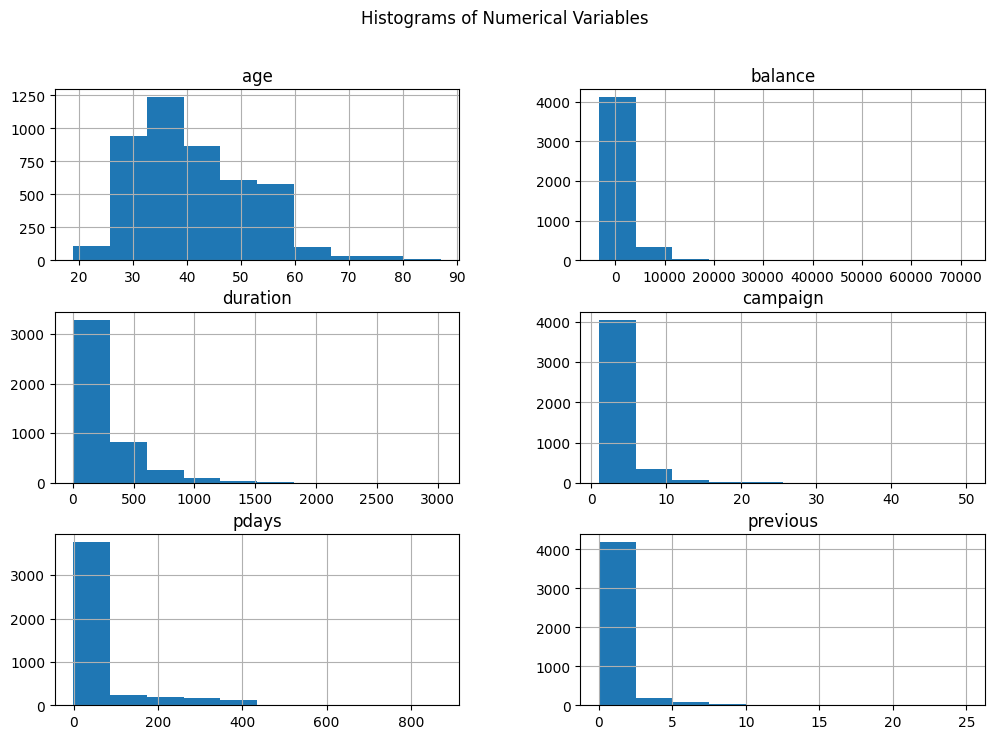

In [17]:
# Histograms
numerical_vars = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
df[numerical_vars].hist(figsize=(12, 8))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

<Axes: xlabel='marital', ylabel='count'>

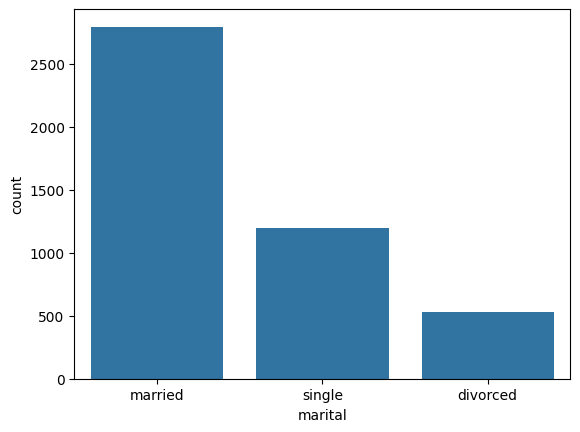

In [18]:
sns.countplot(x='marital',data=df)

<Axes: xlabel='housing', ylabel='count'>

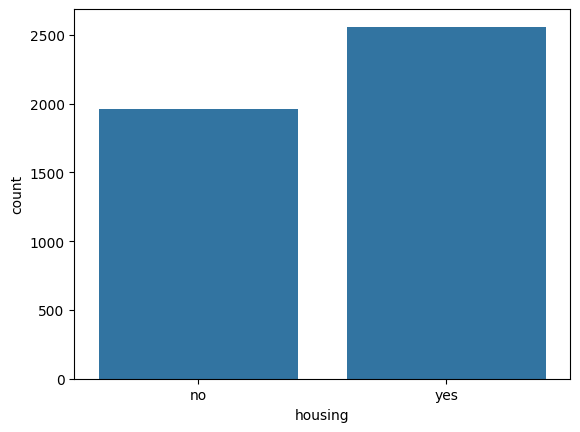

In [19]:
sns.countplot(x='housing',data=df)

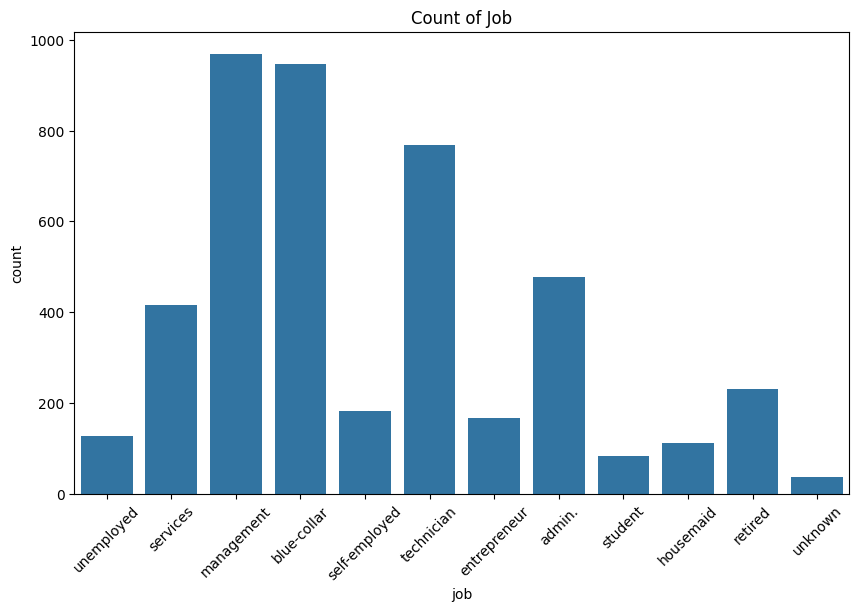

In [20]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='job')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

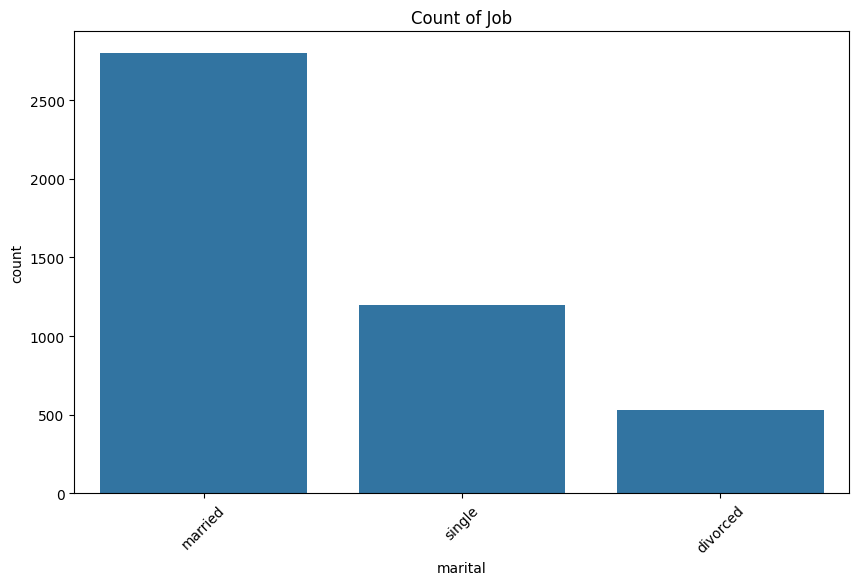

In [21]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='marital')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

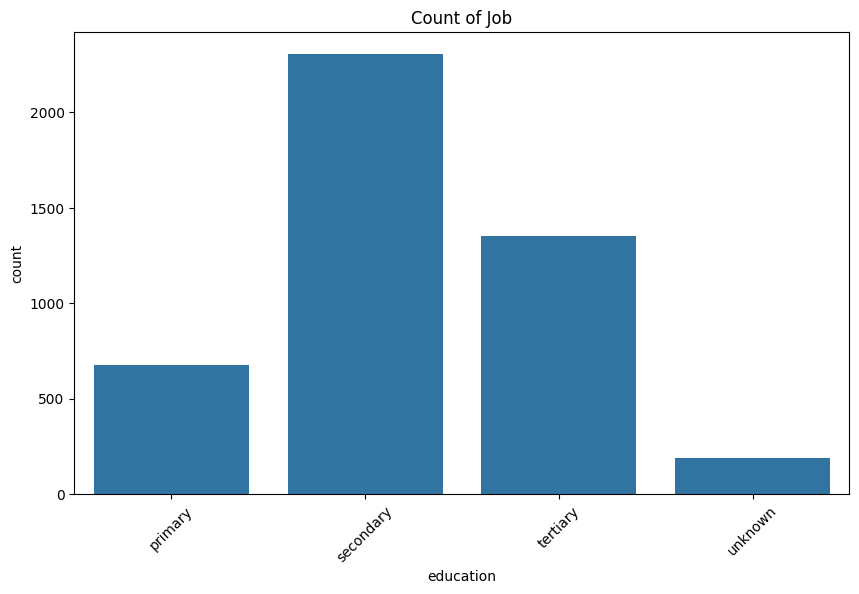

In [22]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='education')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

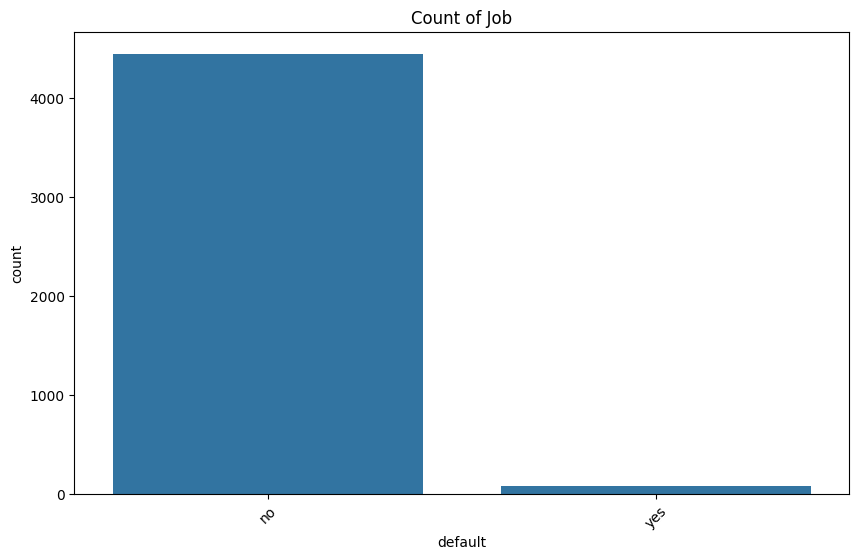

In [23]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='default')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

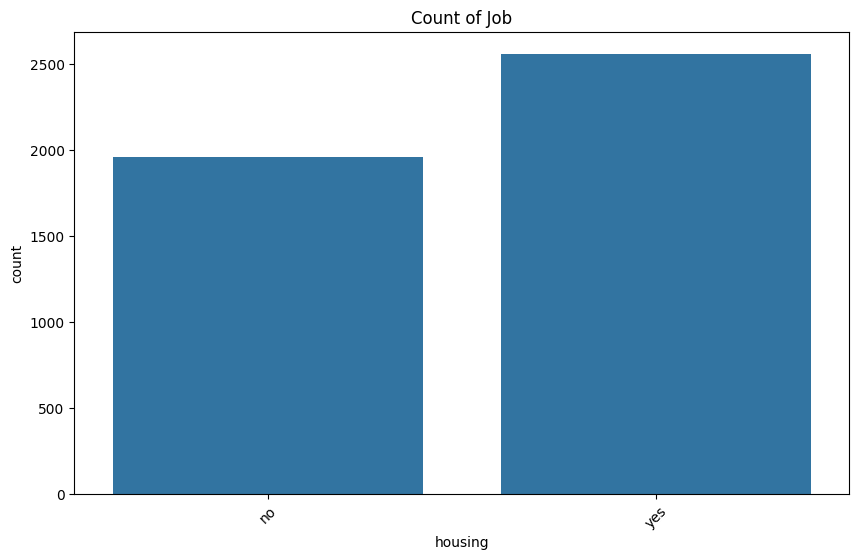

In [24]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='housing')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

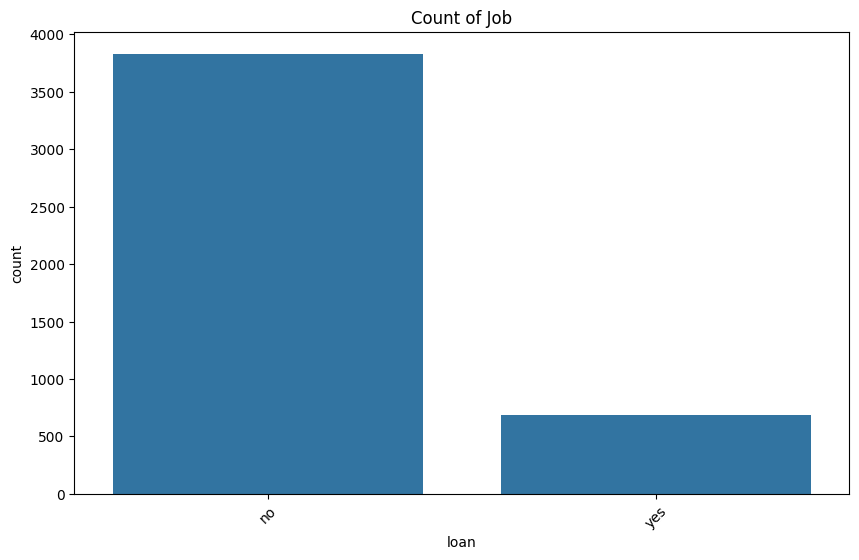

In [25]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

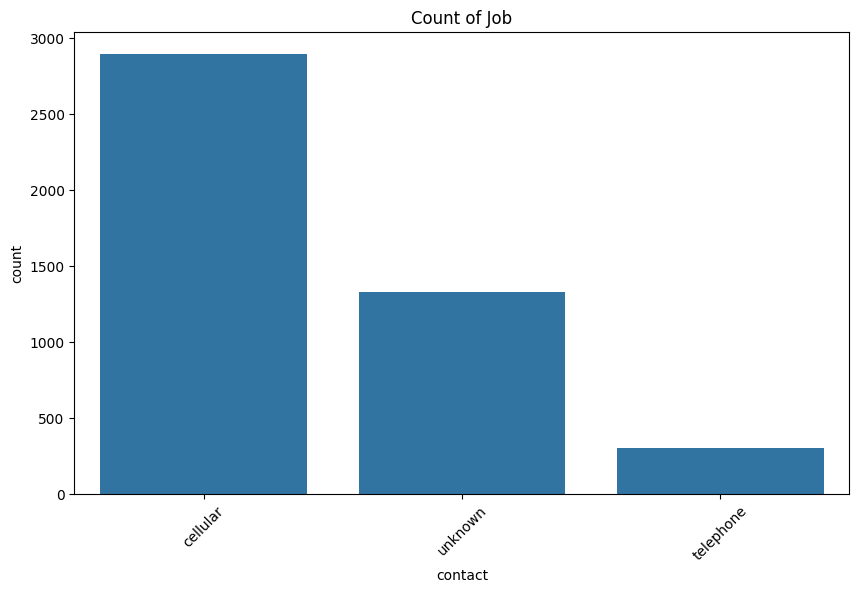

In [26]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='contact')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

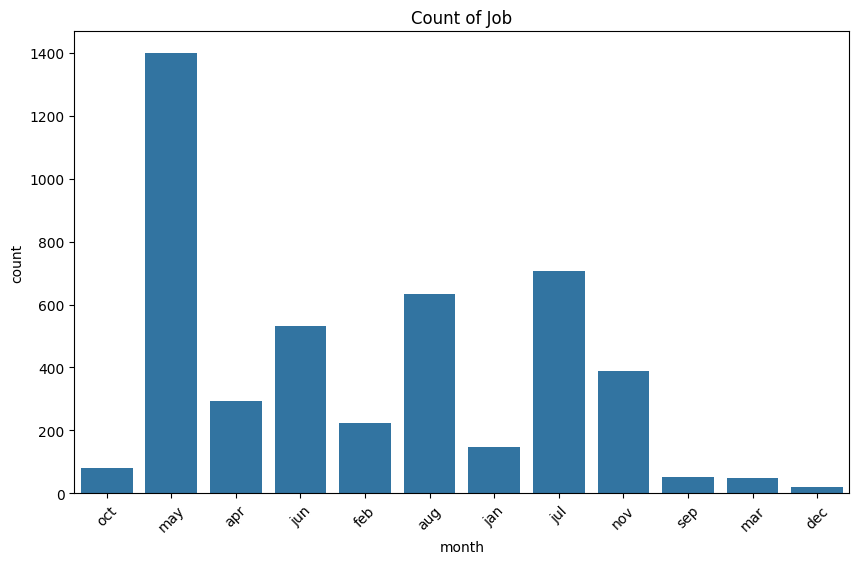

In [27]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='month')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

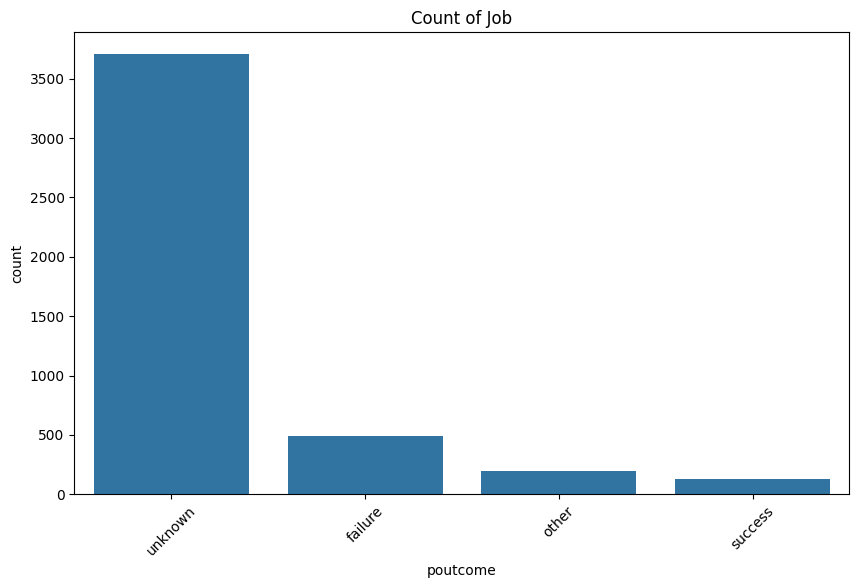

In [28]:
# Bar Chart for the 'job' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='poutcome')
plt.title('Count of Job')
plt.xticks(rotation=45)
plt.show()

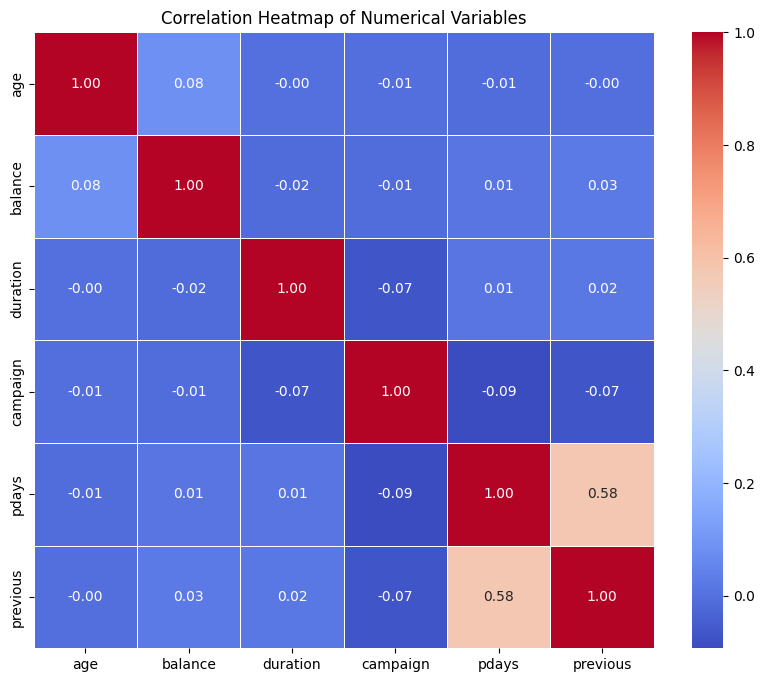

In [29]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

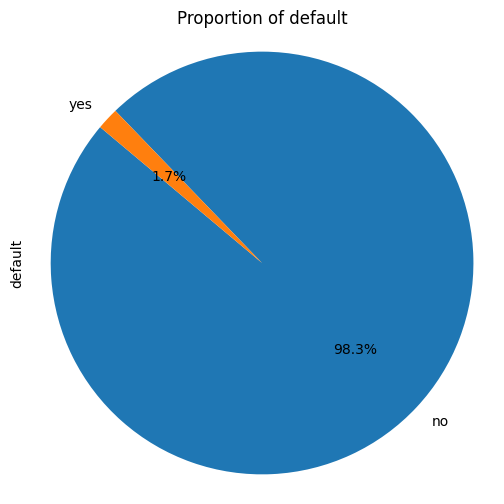

In [30]:
# Pie Charts
default_vars = ['default']
for var in default_vars:
    plt.figure(figsize=(6, 6))
    df[var].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
    plt.title(f'Proportion of {var}')
    plt.axis('equal')
    plt.show()

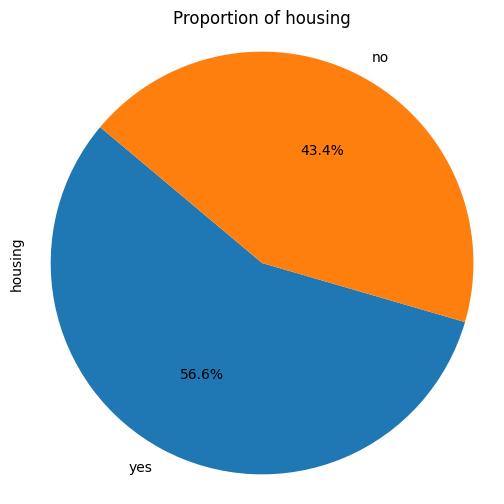

In [31]:
# Pie Charts
default_vars = ['housing']
for var in default_vars:
    plt.figure(figsize=(6, 6))
    df[var].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
    plt.title(f'Proportion of {var}')
    plt.axis('equal')
    plt.show()

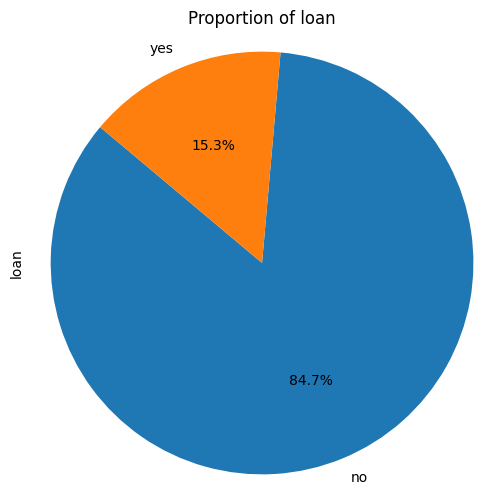

In [32]:
# Pie Charts
default_vars = ['loan']
for var in default_vars:
    plt.figure(figsize=(6, 6))
    df[var].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
    plt.title(f'Proportion of {var}')
    plt.axis('equal')
    plt.show()

In [33]:
df.columns

StringIndex(['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome' 'y'], dtype='object')

In [34]:
categories_1st=["job","marital","education","default","housing","housing","loan","contact","month","poutcome","y"]
LE=LabelEncoder()
for i in categories_1st:
    df[i]=LE.fit_transform(df[i])

In [35]:
df.rename(columns={"y": "loan_approval"}, inplace=True)

In [36]:
df.corr()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,loan_approval
age,1.000000,-0.021500,-0.381485,-0.121613,-0.017885,0.083820,-0.193888,-0.011250,0.015161,-0.017853,-0.040714,-0.002367,-0.005148,-0.008894,-0.003511,-0.009320,0.045092
job,-0.021500,1.000000,0.069390,0.170160,0.008324,0.009797,-0.128353,-0.040245,-0.074068,0.012865,-0.096613,-0.006739,-0.002739,-0.022760,0.005029,0.013049,0.027401
marital,-0.381485,0.069390,1.000000,0.102714,-0.020745,0.024971,-0.029851,-0.045210,-0.068236,0.008794,-0.035855,0.006619,0.005915,0.017050,0.038028,-0.027716,0.015042
education,-0.121613,0.170160,0.102714,1.000000,-0.010534,0.057725,-0.087070,-0.054086,-0.110554,0.014926,-0.050086,-0.014878,-0.001723,0.012077,0.023983,-0.032135,0.042987
default,-0.017885,0.008324,-0.020745,-0.010534,1.000000,-0.070886,0.006881,0.063994,0.008448,-0.013261,0.014297,-0.011615,-0.012348,-0.026317,-0.026656,0.039032,0.001303
balance,0.083820,0.009797,0.024971,0.057725,-0.070886,1.000000,-0.050227,-0.071349,-0.009665,-0.008677,0.023113,-0.015950,-0.009976,0.009437,0.026196,-0.029268,0.017905
housing,-0.193888,-0.128353,-0.029851,-0.087070,0.006881,-0.050227,1.000000,0.018451,0.196454,-0.031291,0.266630,0.015740,-0.003574,0.116893,0.038621,-0.093093,-0.104683
loan,-0.011250,-0.040245,-0.045210,-0.054086,0.063994,-0.071349,0.018451,1.000000,-0.007319,-0.004879,0.016329,-0.004997,0.017120,-0.031086,-0.022115,0.027028,-0.070517
contact,0.015161,-0.074068,-0.068236,-0.110554,0.008448,-0.009665,0.196454,-0.007319,1.000000,-0.033807,0.370077,-0.011380,0.012278,-0.243223,-0.187232,0.267173,-0.133595
day,-0.017853,0.012865,0.008794,0.014926,-0.013261,-0.008677,-0.031291,-0.004879,-0.033807,1.000000,-0.014795,-0.024629,0.160706,-0.094352,-0.059114,0.073714,-0.011244


In [37]:
x=df.iloc[:,:-1]
x

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,7,1,1,0,-333,1,0,0,30,5,329,5,-1,0,3
4517,57,6,1,2,1,-3313,1,1,2,9,8,153,1,-1,0,3
4518,57,9,1,1,0,295,0,0,0,19,1,151,11,-1,0,3
4519,28,1,1,1,0,1137,0,0,0,6,3,129,4,211,3,1


In [38]:
y=df.iloc[:,-1]
y

0       0
1       0
2       0
3       0
4       0
       ..
4516    0
4517    0
4518    0
4519    0
4520    0
Name: loan_approval, Length: 4521, dtype: int64

In [39]:
print(x.shape, y.shape)

(4521, 16) (4521,)


In [40]:
print("Before oversampling:")
print(y.value_counts())
sm=RandomOverSampler()
x,y=sm.fit_resample(x,y)
print("After oversampling:")
print(y.value_counts())

Before oversampling:
0    4000
1     521
Name: loan_approval, dtype: int64
After oversampling:
0    4000
1    4000
Name: loan_approval, dtype: int64


In [41]:
#minmaxscaler
ms=MinMaxScaler()
x=ms.fit_transform(x)
x

array([[0.16176471, 0.90909091, 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.20588235, 0.63636364, 0.5       , ..., 0.38990826, 0.16      ,
        0.        ],
       [0.23529412, 0.36363636, 1.        , ..., 0.37958716, 0.04      ,
        0.        ],
       ...,
       [0.13235294, 0.09090909, 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.41176471, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.22058824, 0.81818182, 0.5       , ..., 0.06536697, 0.04      ,
        0.33333333]])

In [42]:
#splitting to test and train data
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (7200, 16) (7200,)
Test set: (800, 16) (800,)


# **Logistic Regression **

In [43]:
LR = LogisticRegression(C=0.011, solver='liblinear').fit(X_train,y_train)
y_pred = LR.predict(X_test)

In [44]:
y_pred

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [45]:
LR_score=accuracy_score(y_test, y_pred)
LR_F1_SCORE=f1_score(y_test, y_pred, average='weighted')
print('F1_score:%.4f'%LR_F1_SCORE)
print('Accuracy: %f' % accuracy_score(y_test, y_pred))

F1_score:0.6643
Accuracy: 0.665000


In [46]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       362
           1       0.71      0.66      0.68       438

    accuracy                           0.67       800
   macro avg       0.66      0.67      0.66       800
weighted avg       0.67      0.67      0.67       800



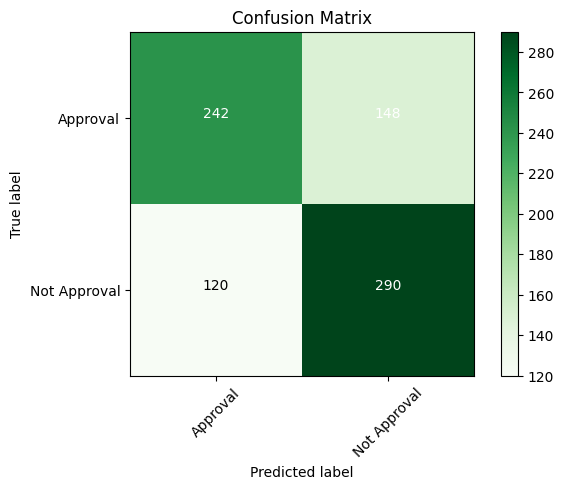

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Example usage
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['Approval', 'Not Approval']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.Greens)
plt.show()

#**Support Vector Machine Algorithm**

In [48]:
clf = svm.SVC(C=10, gamma =1,kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [49]:
y_pred = clf.predict(X_test)
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,

In [50]:
SVM_score=accuracy_score(y_test, y_pred)
SVM_F1_SCORE=f1_score(y_test, y_pred, average='weighted')
print('F1_score:%.4f'%SVM_F1_SCORE)
print('Accuracy: %f' % accuracy_score(y_test, y_pred))

F1_score:0.8973
Accuracy: 0.897500


In [51]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       362
           1       0.93      0.87      0.90       438

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



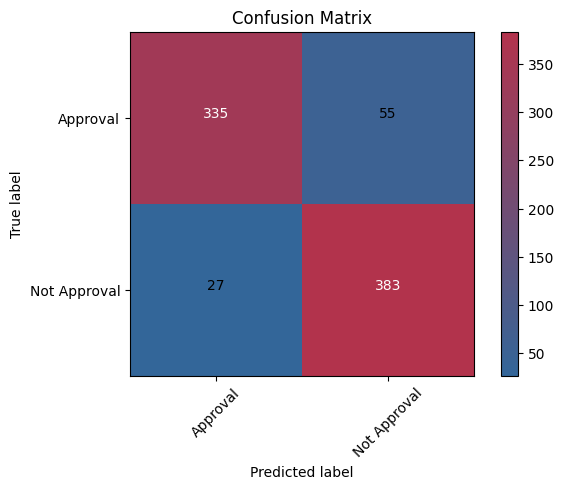

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if cmap is None:
        cmap = plt.cm.Blues  # Default colormap if not provided

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define custom colormap with two colors
from matplotlib.colors import LinearSegmentedColormap

colors = [(0.2, 0.4, 0.6), (0.7, 0.2, 0.3)]  # Specify your two colors here
cmap_custom = LinearSegmentedColormap.from_list('custom', colors)

# Example usage
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['Approval', 'Not Approval']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion Matrix', cmap=cmap_custom)
plt.show()


# **KNN**

In [53]:
x_train_norm = preprocessing.StandardScaler().fit(X_train).transform(X_train)
x_train_norm[0:5]

array([[ 0.6218136 ,  0.16152368,  1.33966355, -1.68555599, -0.1334605 ,
         8.42653385, -1.03218432, -0.37097234,  1.81504634,  0.15620694,
         0.19581203, -0.85801872, -0.58306341, -0.48012588, -0.41606513,
         0.52573545],
       [-0.65137998,  1.41169354, -0.25306722, -0.34485746, -0.1334605 ,
        -0.52326602,  0.96881921, -0.37097234, -0.6133349 ,  1.61290202,
        -1.37732633, -0.79590327,  0.51122538, -0.48012588, -0.41606513,
         0.52573545],
       [-0.14210255, -0.15101878,  1.33966355,  0.99584108, -0.1334605 ,
        -0.05158551, -1.03218432, -0.37097234, -0.6133349 ,  1.61290202,
        -0.43344332,  3.03549084, -0.58306341, -0.48012588, -0.41606513,
         0.52573545],
       [-0.22698212,  1.41169354, -0.25306722,  2.33653961, -0.1334605 ,
        -0.23249457, -1.03218432, -0.37097234,  1.81504634,  1.73429328,
         0.82506737,  1.20590839, -0.21830048, -0.48012588, -0.41606513,
         0.52573545],
       [-0.39674127, -0.77610371,  1

In [54]:
k = 3
#Train Model and Predict
neigh = KNeighborsClassifier(n_neighbors = k).fit(x_train_norm,y_train)
neigh

KNeighborsClassifier(n_neighbors=3)

In [55]:
x_test_norm = preprocessing.StandardScaler().fit(X_test).transform(X_test)
x_test_norm[0:5]

array([[ 0.14828283, -1.15160245, -1.81365446, -1.77247756, -0.12852402,
        -0.59840762,  0.98511083, -0.36268681,  1.74846742, -0.89096054,
         0.79818805, -0.80002502, -0.54773331, -0.45811723, -0.36808822,
         0.4928179 ],
       [-0.27873756, -0.21023805, -0.26186455,  2.42687697, -0.12852402,
         1.00798701, -1.01511421, -0.36268681, -0.62636099,  1.06585053,
         1.10846523, -0.11764832, -0.19090379,  1.39479414,  0.15217781,
        -0.55018294],
       [-0.62035386,  0.41733822,  1.28992536,  1.02709213, -0.12852402,
        -0.41030414, -1.01511421, -0.36268681, -0.62636099,  0.57664776,
        -1.37375222,  4.06978779,  0.16592573, -0.45811723, -0.36808822,
         0.4928179 ],
       [ 0.48989914, -1.15160245, -0.26186455, -0.37269271, -0.12852402,
         0.28836594, -1.01511421, -0.36268681,  1.74846742, -1.3801633 ,
         0.17763369,  1.01142477, -0.19090379, -0.45811723, -0.36808822,
         0.4928179 ],
       [ 2.88121329,  0.10355008, -1

In [56]:
y_pred = neigh.predict(x_test_norm)
y_pred[0:5]

array([0, 1, 1, 1, 1])

In [57]:
knn_score=accuracy_score(y_test, y_pred)
kNN_F1_SCORE=f1_score(y_test, y_pred, average='weighted')
print('F1_score:%.4f'%kNN_F1_SCORE)
print("Test set Accuracy: ", accuracy_score(y_test, y_pred))

F1_score:0.9372
Test set Accuracy:  0.9375


In [58]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       340
           1       1.00      0.89      0.94       460

    accuracy                           0.94       800
   macro avg       0.94      0.95      0.94       800
weighted avg       0.95      0.94      0.94       800



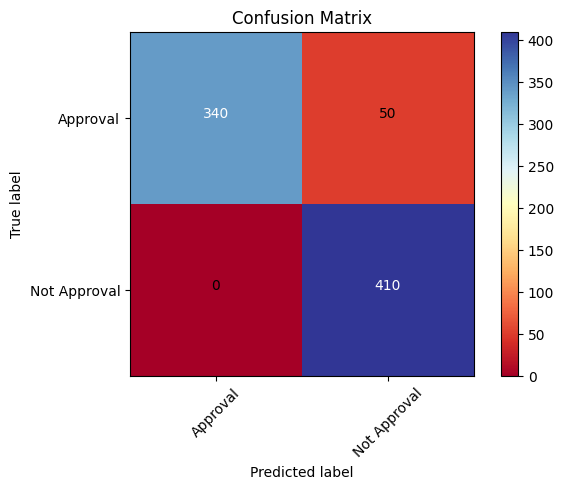

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdYlBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Example usage
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['Approval', 'Not Approval']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.RdYlBu)
plt.show()


# **Random Forest**

In [60]:
forest = RandomForestClassifier(criterion='entropy',max_depth= None, min_samples_leaf= 1, min_samples_split= 4)
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=4)

In [61]:
y_pred = forest.predict(X_test)

In [62]:
rand_score=accuracy_score(y_test, y_pred)
RAnd_F1_SCORE=f1_score(y_test, y_pred, average='weighted')
print('F1_score:%.4f'%RAnd_F1_SCORE)
print('Accuracy: %f' % accuracy_score(y_test, y_pred))

F1_score:0.9775
Accuracy: 0.977500


In [63]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       372
           1       1.00      0.96      0.98       428

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



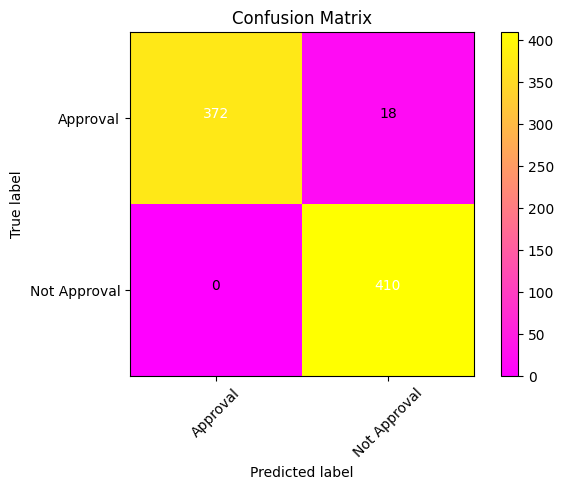

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Example usage
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['Approval', 'Not Approval']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.spring)
plt.show()


In [65]:
Accuracy=[LR_score*100,knn_score*100,SVM_score*100,round(rand_score*100)]
Algorithm=['logistic regression','SVM','KNN','Random forest']
f1_score=[LR_F1_SCORE*100,kNN_F1_SCORE*100,SVM_F1_SCORE*100,RAnd_F1_SCORE*100]
data={'Algorithm':Algorithm,'Accuracy':Accuracy,'F1_SCORE':f1_score}
Report=pd.DataFrame(data=data)
Report

,Algorithm,Accuracy,F1_SCORE
0,logistic regression,66.50,66.429396
1,SVM,93.75,93.715557
2,KNN,89.75,89.728397
3,Random forest,98.00,97.747590


# RNN Approch

<h3>LSTM:</h3>
LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN). Both LSTM and traditional RNNs are neural network architectures designed for processing sequences of data. They are particularly well-suited for tasks involving sequential or time-dependent patterns, such as time series analysis, natural language processing, and speech recognition.

Epoch 1/50
225/225 [==============================] - 2s 9ms/step - loss: 0.4415 - accuracy: 0.8028 - val_loss: 0.4804 - val_accuracy: 0.7962
Epoch 2/50
225/225 [==============================] - 1s 7ms/step - loss: 0.4398 - accuracy: 0.8033 - val_loss: 0.4789 - val_accuracy: 0.7950
Epoch 3/50
225/225 [==============================] - 1s 6ms/step - loss: 0.4381 - accuracy: 0.8061 - val_loss: 0.4756 - val_accuracy: 0.7950
Epoch 4/50
225/225 [==============================] - 1s 5ms/step - loss: 0.4368 - accuracy: 0.8035 - val_loss: 0.4740 - val_accuracy: 0.7975
Epoch 5/50
225/225 [==============================] - 1s 4ms/step - loss: 0.4362 - accuracy: 0.8068 - val_loss: 0.4808 - val_accuracy: 0.7900
Epoch 6/50
225/225 [==============================] - 1s 4ms/step - loss: 0.4340 - accuracy: 0.8032 - val_loss: 0.4830 - val_accuracy: 0.7875
Epoch 7/50
225/225 [==============================] - 1s 4ms/step - loss: 0.4323 - accuracy: 0.8033 - val_loss: 0.4732 - val_accuracy: 0.7937
Epoch 

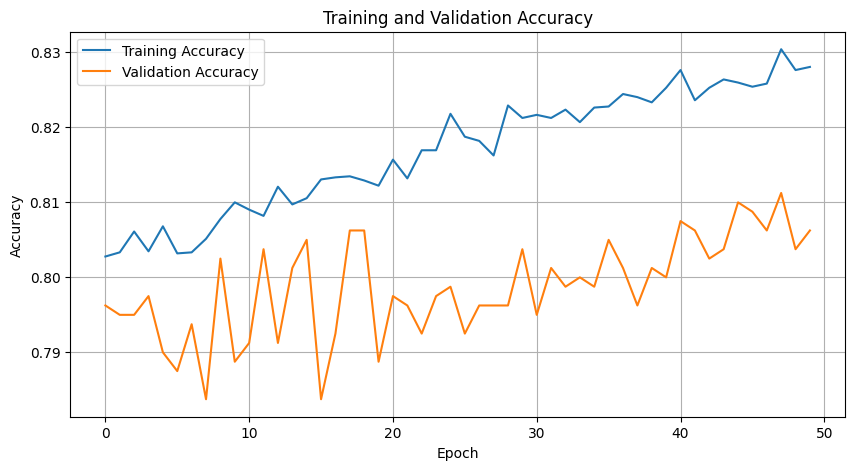

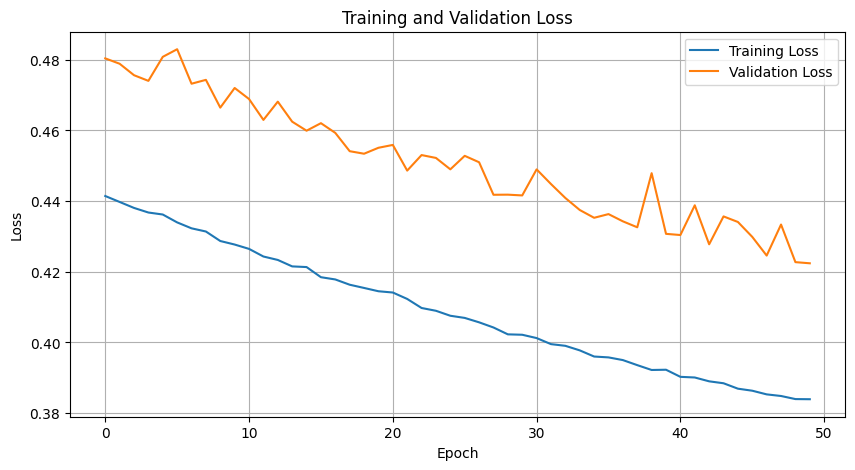

25/25 [==============================] - 0s 3ms/step - loss: 0.4224 - accuracy: 0.8062
Model Accuracy: 80.62%


In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Reshape data for LSTM (assuming you have a time series dataset)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train the model and record history
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
_, accuracy = model.evaluate(X_test_lstm, y_test)
print(f'Model Accuracy: {accuracy * 100:.2f}%')